<a href="https://colab.research.google.com/github/injilashah/Evaluating-LLMs/blob/main/Bloom_Gemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prompting multilingual models

##**Loading IN22-Conv Datset for Translation from Hugging Face**

In [ ]:
!pip install --quiet datasets


In [ ]:

from datasets import load_dataset,DatasetDict
import pandas as pd
#load dataset from hf
datasetdict =load_dataset("ai4bharat/IN22-Conv","eng_Latn-hin_Deva",  trust_remote_code=True)

#loading "conv" split from Datasetdict
dataset=datasetdict["conv"]

#converting the dataset to pandas dataframe
translationdata  =pd.DataFrame( dataset)

#Taking random 100 samples
translationdata=translationdata.sample(n =100)

#storing  only the englsih and hindi columns to df
translationdata =translationdata[['sentence_eng_Latn','sentence_hin_Deva']]

#creating an extra index columns for better indexing of rows
translationdata['index'] =range(0,len(translationdata))
translationdata

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.74k [00:00<?, ?B/s]

IN22-Conv.py:   0%|          | 0.00/7.95k [00:00<?, ?B/s]

Generating conv split: 0 examples [00:00, ? examples/s]

sentence_eng_Latn  \
491   Don't judge me, but this is my first ever road...   
711   You should try to incorporate some enjoyable h...   
207                                That is the problem.   
284   Odisha is one the places, faces extreme weathe...   
363   After we saw the skin allergies occurring in m...   
...                                                 ...   
882   Can you please check with my credit score and ...   
1231  Ma'am, I heard that if you enroll at a particu...   
404                      Then I'll aim for the try-outs   
1156          It is completely in Dravida architecture.   
1394              Sir, please proceed to Counter No. 2.   

                                      sentence_hin_Deva  index  
491   मुझे जज मत करने लगना, लेकिन यह मेरी पहली रोड ट...      0  
711   आपको इस परेशानी से छुटकारा पाने के लिए उसे कुछ...      1  
207                                 यही तो प्रॉब्लम है।      2  
284   ओडिशा उन जगहों में से एक है जहाँ इन दिनों मौसम...      3  
363   जब हमने गांव के कई लोगों में चमड़ी की अलर्जी द...      4  
...                                                 ...    ...  
882   क्या आप मेरा क्रेडिट स्कोर देखकर बता सकती हैं ...     95  
1231  मैम, मैंने सुना है कि यदि आप किसी निर्धारित जग...     96  
404   फिर मैं योग्यता की परीक्षा में जाने की तैयारी ...     97  
1156         ये पूरी तरह से द्रविड़ आर्किटेक्चर में है।     98  
1394                    सर, कृपया काउंटर नं. 2 पर जाएँ।     99  

[100 rows x 3 columns]

##Implementation code for generating Bloom_Transalations

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM


# Translation Class
class Translation:
     def __init__(self, model_name,Tokenizer):
            #define class instances
            self.model_name=model_name
            self.Tokenizer =Tokenizer


    # this functions processes inputs and returns translations
     def translate_batch(self, batch, prompt):
        translations =[]
        for sentence in batch:
            input_text  =f"{prompt}{sentence}."#prompt =predefined prompt from Translation_propmts dictionary and sentence is input row of first or second column from batch.
            inputs =self.Tokenizer(input_text, return_tensors="pt").to("cuda")#tokenizes inputs

            #generates tokenized outputs from input_ids(numerical representation of tokens)
            outputs =self.model_name.generate(input_ids=inputs['input_ids'].cuda(), max_new_tokens=31, num_return_sequences=1)

            #decode the generated tokens back to normal text
            translation = self.Tokenizer.decode(outputs[0], skip_special_tokens=True)

            #to strip the prompt generated by model from the output translation.
            translation =translation.replace(prompt, "").strip()

            translations.append(translation)
        return translations

# Main Program for Translation
class Main:

    def __init__(self, dataset_translation,batch_siz):
       #initialize class instances
        self.dataset_translation =dataset_translation
        self.batch_siz =batch_siz
        #returns no of batches
        self.num_translation_batches =100 //self.batch_size  #100=no of rows in dataframe


    def process_translation(self):
        # Initialize Bloom
        Tokenizer =  AutoTokenizer.from_pretrained("bigscience/bloom-1b7")
        Model1 =AutoModelForCausalLM.from_pretrained("bigscience/bloom-1b7", device_map="auto",load_in_4bit=True)
        bloom_translator =Translation(Model1,Tokenizer)

        #defining columns for resulting dataframe
        results_df = pd.DataFrame(columns= [
            "Batch", "sentence_eng_Latn", "sentence_hin_Deva", "Bloom_hin-to-eng_0-shot", "Bloom_hin-to-eng_1-shot", "Bloom_hin-to-eng_4-shot", "Bloom_eng-to-hin_0-shot", "Bloom_eng-to-hin_1-shot", "Bloom_eng-to-hin_4-shot"])

        for batch_num in range(self.num_translation_batches):
            start_idx = batch_num * self.batch_siz #initialze start index for each batch
            end_idx = start_idx + self.batch_siz   #initilaize end index for each batch
            batch = self.dataset_translation.iloc[start_idx:end_idx]#e.g(for batch size =20 and batch_num = 2, the value will be [20:39]

            #to show current status ..also helped in debugging
            print(f"Processing batch {batch_num + 1}: start_idx={start_idx}, end_idx={end_idx}, size={len(batch)}")

            # Extract English and HIndi columns from the batch
            english_sentences = batch["sentence_eng_Latn"].tolist()
            hindi_sentences = batch["sentence_hin_Deva"].tolist()

            # Bloom translations (Hindi to English and English to Hindi)

            #translations are returned here  #bloom_translator is an object instance of Translation class.   #accessing each propmt
            bloom_hin_to_english_zero_shot = bloom_translator.translate_batch(hindi_sentences, Translation_prompts["hin_to_eng_zero_shot"])
            bloom_hin_to_english_one_shot = bloom_translator.translate_batch(hindi_sentences, Translation_prompts["hin_to_eng_one_shot"])
            bloom_hin_to_english_four_shot = bloom_translator.translate_batch(hindi_sentences, Translation_prompts["hin_to_eng_four_shot"])

            bloom_english_to_hin_zero_shot = bloom_translator.translate_batch(english_sentences, Translation_prompts["eng_to_hin_zero_shot"])
            bloom_english_to_hin_one_shot = bloom_translator.translate_batch(english_sentences, Translation_prompts["eng_to_hin_one_shot"])
            bloom_english_to_hin_four_shot = bloom_translator.translate_batch(english_sentences, Translation_prompts["eng_to_hin_four_shot"])


            # Compile results to pandas dataferame
            batch_data = pd.DataFrame(
                {"Batch": [batch_num + 1] * len(batch),
                "sentence_eng_Latn": batch["sentence_eng_Latn"],
                "sentence_hin_Deva": batch["sentence_hin_Deva"],
                 "Bloom_hin-to-eng_0-shot": bloom_hin_to_english_zero_shot,
                  "Bloom_hin-to-eng_1-shot": bloom_hin_to_english_one_shot,
                "Bloom_hin-to-eng_4-shot": bloom_hin_to_english_four_shot,
                "Bloom_eng-to-hin_0-shot": bloom_english_to_hin_zero_shot,
                "Bloom_eng-to-hin_1-shot": bloom_english_to_hin_one_shot,
                "Bloom_eng-to-hin_4-shot": bloom_english_to_hin_four_shot,})
            #concatenate results after each iteration
            results =pd.concat([results_df,batch_data], ignore_index=True)

        # Save results
        results.to_csv("bloomtranslations.csv",index=False)

        print("Results saved")



# store Predefined Prompts to dictionary
Translation_prompts ={
      "eng_to_hin_zero_shot": "Translate the Sentence to Hindi language:",
      "eng_to_hin_one_shot": "Translate the Sentence from English to Hindi.Example sentence:'But make sure you watch the part of the parade'translates to Hindi as'लेकिन प्रतियोगि+ता के कारण परेड का जो भाग मैं म'.Now translate the sentence:",
      "eng_to_hin_four_shot": """Translate the sentence from English to Hindi.Given some example sentences like:'But make sure you watch the part of the parade'translates to Hindi as'लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'.'I will hear about it at bedtime'translates to Hindi as'रात को सोने से पहले उसके बारे में सुनूंगी।'.'Hello, is this Samadhan helpline?'translates to Hindi as'हेलो, क्या यह समाधान हेल्पलाइन है?'.'Yes, how can I help you?'translates to Hindi as'हाँ, मैं आपकी कैसे सहायता कर सकता हूँ?'.Now translate the sentence:""",
       "hin_to_eng_zero_shot": "Translate the given sentence to English language:",
      "hin_to_eng_one_shot": "Translate the sentence from Hindi to English.Example sentence:लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'translates to English as'But make sure you watch the part of the parade'.Now translate the sentence:",
        "hin_to_eng_four_shot": """Translate the sentence from Hindi to English.Given some example sentences like:'लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'translates to English as'But make sure you watch the part of the parade'.'रात को सोने से पहले उसके बारे में सुनूंगी।'translates to English as'I will hear about it at bedtime'.'हेलो, क्या यह समाधान हेल्पलाइन है?'translates to English as'Hello, is this Samadhan helpline?'.'हाँ, मैं आपकी कैसे सहायता कर सकता हूँ?'translates to English as'Yes, how can I help you?'.Now translate the sentence:"""
   }


#batch_size =int(input("enter batch size"))
batch_siz =20
#create obj of Main class
run_main= Main(translationdata, batch_siz)
#call to method of Main class
run_main.process_translation()

##Implementation code for generating GEMMA_Translations

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM

# store Predefined Prompts to dictionary
PROMPTS = {
         "eng_to_hin_zero_shot": "Translate the Sentence to Hindi language:",
        "eng_to_hin_one_shot": "Translate the Sentence from English to Hindi.Example sentence:'But make sure you watch the part of the parade'translates to Hindi as'लेकिन प्रतियोगि+ता के कारण परेड का जो भाग मैं म'.Now translate the sentence:",
        "eng_to_hin_four_shot": "Translate the sentence from English to Hindi.Given some example sentences like:'But make sure you watch the part of the parade'translates to Hindi as'लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'.'I will hear about it at bedtime'translates to Hindi as'रात को सोने से पहले उसके बारे में सुनूंगी।'.'Hello, is this Samadhan helpline?'translates to Hindi as'हेलो, क्या यह समाधान हेल्पलाइन है?'.'Yes, how can I help you?'translates to Hindi as'हाँ, मैं आपकी कैसे सहायता कर सकता हूँ?'.Now translate the sentence:",
"hin_to_eng_zero_shot": "Translate the given sentence to English language:",
        "hin_to_eng_one_shot": "Translate the sentence from Hindi to English.Example sentence:लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'translates to English as'But make sure you watch the part of the parade'.Now translate the sentence:",
        "hin_to_eng_four_shot": "Translate the sentence from Hindi to English.Given some example sentences like:'लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'translates to English as'But make sure you watch the part of the parade'.'रात को सोने से पहले उसके बारे में सुनूंगी।'translates to English as'I will hear about it at bedtime'.'हेलो, क्या यह समाधान हेल्पलाइन है?'translates to English as'Hello, is this Samadhan helpline?'.'हाँ, मैं आपकी कैसे सहायता कर सकता हूँ?'translates to English as'Yes, how can I help you?'.Now translate the sentence:"}

# Translation Class
class Translation:
     def __init__(self, model_name,Tokenizer):

#define class instances
            self.model_name=model_name
            self.Tokenizer=Tokenizer





     def translate_batch(self,batch,prompt):
        translations =[]
        for sentence in batch:
            input_text   =f"{prompt}{sentence}."#prompt =predefined prompt from Translation_propmts dictionary and sentence is input row of first or second column from batch.
            inputs =self.Tokenizer(input_text, return_tensors="pt").to("cuda")#tokenizes inputs

            #generates tokenized outputs from input_ids(numerical representation of tokens)
            outputs =self.model_name.generate(input_ids=inputs['input_ids'].cuda(), max_new_tokens=31, num_return_sequences=1)

            #decode the generated tokens back to normal text
            translation =self.Tokenizer.decode(outputs[0],skip_special_tokens=True)

            #to strip the prompt generated by model from the output translation.
            translation = translation.replace(prompt, "").strip()

            translations.append(translation)
        return translations

# Main Program for Translation
class Main:
    def __init__(self, dataset_translation,batch_siz):
        self.dataset_translation = dataset_translation
        self.batch_siz = batch_siz
        self.num_translation_batches = len(dataset_translation) // self.batch_siz #100=no of rows in dataframe

    def process_translation(self):
        # Initialize Gemma from AutoTokenizer class and gemma model from AutoModelForCausalLM


        Tokenizer = AutoTokenizer.from_pretrained( "google/gemma-2-2b" )
        Model2 = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b", device_map="auto",load_in_4bit=True)
        gemma_translator = Translation(Model2,Tokenizer )
        #defining columns for resulting dataframe
        results_df = pd.DataFrame( columns=[
            "Batch","sentence_eng_Latn","sentence_hin_Deva","Gemma_hin-to-eng_0-shot","Gemma_hin-to-eng_1-shot","Gemma_hin-to-eng_4-shot","Gemma_eng-to-hin_0-shot", "Gemma_eng-to-hin_1-shot", "Gemma_eng-to-hin_4-shot"])

        print("Dataset size:", len(self.dataset_translation ) )

        for batch_num in range(self.num_translation_batches ):

            start_idx = batch_num * self.batch_siz  #initialze start index for each batch
            end_idx = start_idx + self.batch_siz #initilaize end index for each batch
            batch = self.dataset_translation.iloc[start_idx:end_idx]#e.g(for batch size =20 and batch_num = 2, the value will be [20:39]

            #to show current status ..also helped in debugging
            print(f"Processing batch {batch_num + 1}: start_idx={start_idx}, end_idx={end_idx}, size={len(batch)}" )

            # Extract English and HIndi columns from the batch
            english_sentences = batch["sentence_eng_Latn"].tolist()
            hindi_sentences = batch["sentence_hin_Deva"].tolist()

            #translations are returned here  #gemma_translator is an object instance of Translation class.   #accessing each propmt
            gemma_english_to_hin_zero_shot = gemma_translator.translate_batch(english_sentences, PROMPTS["eng_to_hin_zero_shot"])
            gemma_english_to_hin_one_shot = gemma_translator.translate_batch(english_sentences, PROMPTS["eng_to_hin_one_shot"])
            gemma_english_to_hin_four_shot = gemma_translator.translate_batch(english_sentences, PROMPTS["eng_to_hin_four_shot"])


            gemma_hin_to_eng_zero_shot = gemma_translator.translate_batch(hindi_sentences, PROMPTS["hin_to_eng_zero_shot"])
            gemma_hin_to_eng_one_shot = gemma_translator.translate_batch(hindi_sentences, PROMPTS["hin_to_eng_one_shot"])
            gemma_hin_to_eng_four_shot = gemma_translator.translate_batch(hindi_sentences, PROMPTS["hin_to_eng_four_shot"])

            # Compile results to pandas dataferame
            batch_data = pd.DataFrame(
                {"Batch": [batch_num + 1] * len(batch),
                "sentence_eng_Latn": batch["sentence_eng_Latn"],
                "sentence_hin_Deva": batch["sentence_hin_Deva"],
                "Gemma_eng-to-hin_0-shot": gemma_english_to_hin_zero_shot,
                "Gemma_eng-to-hin_1-shot": gemma_english_to_hin_one_shot,
              "Gemma_eng-to-hin_4-shot": gemma_english_to_hin_four_shot,
                 "Gemma_hin-to-eng_0-shot": gemma_hin_to_eng_zero_shot,
                 "Gemma_hin-to-eng_1-shot": gemma_hin_to_eng_one_shot,
                 "Gemma_hin-to-eng_4-shot": gemma_hin_to_eng_four_shot,})
            #concatenate results after each iteration
            results_df = pd.concat([results_df, batch_data], ignore_index=True)

        # Save results
        results_df.to_csv("gemmatranslation_results.csv", index=False)

        print("Results saved")





#batch_size =int(input("enter batch size"))
batch_siz = 20
#create obj of Main class
processor = Main(translationdata, batch_siz)
#call to method of Main class
processor.process_translation()


tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Dataset size: 100
Processing batch 1: start_idx=0, end_idx=20, size=20


The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Processing batch 2: start_idx=20, end_idx=40, size=20
Processing batch 3: start_idx=40, end_idx=60, size=20
Processing batch 4: start_idx=60, end_idx=80, size=20
Processing batch 5: start_idx=80, end_idx=100, size=20
Results saved


##Implementation code for Evaluation of Generated Translations

In [ ]:
#checking file contents
import pandas as pd
ds= pd.read_csv("/content/bloom4bit20btranslations")
df =pd.DataFrame(ds)
df



Batch                                  sentence_eng_Latn  \
0       1                I'll come next time for sure, then.   
1       1                               Yes, please come in.   
2       1  Painting, Sculpture, Literature, Architecture,...   
3       1               We have 3 schools in the slum areas.   
4       1  The weather is fine, though the summers are qu...   
..    ...                                                ...   
95      5  No, I just asked, as you said, you joined the ...   
96      5    I think that is what he is best remembered for.   
97      5  What is the rate of interest currently on pers...   
98      5  A lot of Assamese spices also go into its making.   
99      5                             What are the benefits?   

                                    sentence_hin_Deva  \
0                        तब मैं अगली बार ज़रूर आउंगा।   
1                                 जी हाँ, प्लीज़ आइए।   
2   इनमें चित्रकला, मूर्तिकला, साहित्य, वास्तुकला,...   
3    झुग्गी-झोपड़ी वाले इलाकों में हमारे 3 स्कूल हैं।   
4   मौसम ठीक है, हालाँकि गर्मियों में बहुत गर्मी औ...   
..                                                ...   
95  नहीं, मैंने बस पूछा, आपने कहा था न कि आपने म्य...   
96  मुझे लगता है कि उन्हें सबसे ज़्यादा इसी के लिए...   
97            फ़िलहाल पर्सनल लोन पर ब्याज दर क्या है?   
98  इसे बनाने में असम के कई मसालों का भी इस्तेमाल ...   
99                              क्या फ़ायदे हैं इसके?   

                              Bloom_hin-to-eng_0-shot  \
0   तब मैं अगली बार ज़रूर आउंगा।.',\n'translatewik...   
1                                जी हाँ, प्लीज़ आइए।.   
2   इनमें चित्रकला, मूर्तिकला, साहित्य, वास्तुकला,...   
3   झुग्गी-झोपड़ी वाले इलाकों में हमारे 3 स्कूल हैं।.   
4   मौसम ठीक है, हालाँकि गर्मियों में बहुत गर्मी औ...   
..                                                ...   
95  नहीं, मैंने बस पूछा, आपने कहा था न कि आपने म्य...   
96  मुझे लगता है कि उन्हें सबसे ज़्यादा इसी के लिए...   
97           फ़िलहाल पर्सनल लोन पर ब्याज दर क्या है?.   
98  इसे बनाने में असम के कई मसालों का भी इस्तेमाल ...   
99                             क्या फ़ायदे हैं इसके?.   

                              Bloom_hin-to-eng_4-shot  \
0   तब मैं अगली बार ज़रूर आउंगा।.'translates to En...   
1   जी हाँ, प्लीज़ आइए।.'translates to English as'...   
2   इनमें चित्रकला, मूर्तिकला, साहित्य, वास्तुकला,...   
3   झुग्गी-झोपड़ी वाले इलाकों में हमारे 3 स्कूल है...   
4   मौसम ठीक है, हालाँकि गर्मियों में बहुत गर्मी औ...   
..                                                ...   
95  नहीं, मैंने बस पूछा, आपने कहा था न कि आपने म्य...   
96  मुझे लगता है कि उन्हें सबसे ज़्यादा इसी के लिए...   
97  फ़िलहाल पर्सनल लोन पर ब्याज दर क्या है?.'Curre...   
98  इसे बनाने में असम के कई मसालों का भी इस्तेमाल ...   
99  क्या फ़ायदे हैं इसके?.'What are the benefits o...   

                                 Bloom_eng-hin_0-shot  \
0   I'll come next time for sure, then.."\n"If you...   
1                               Yes, please come in..   
2   Painting, Sculpture, Literature, Architecture,...   
3               We have 3 schools in the slum areas..   
4   The weather is fine, though the summers are qu...   
..                                                ...   
95  No, I just asked, as you said, you joined the ...   
96   I think that is what he is best remembered for..   
97  What is the rate of interest currently on pers...   
98  A lot of Assamese spices also go into its maki...   
99  What are the benefits?. The benefits of the se...   

                                 Bloom_eng-hin_1-shot  \
0   I'll come next time for sure, then..'translate...   
1   Yes, please come in..'translates to Hindi as'ह...   
2   Painting, Sculpture, Literature, Architecture,...   
3   We have 3 schools in the slum areas..'translat...   
4   The weather is fine, though the summers are qu...   
..                                                ...   
95  No, I just asked, as you said, you joined the ...   
96  I think that is what he is best rem

In [ ]:

#sacrebleu for  using required metric
!pip install --quiet -U sacrebleu



In [ ]:
!pip install --quiet evaluate

In [ ]:
import pandas as pd
import sacrebleu
import evaluate

class TranslationEvaluator:
    def __init__(self, filepath, required_columns):

        self.df = pd.read_csv(filepath)
        self.required_columns = required_columns

    def evaluate_ter(self, references,translations):

        references = references.tolist()  # Convert to list
        translations = translations.tolist()  # Convert to list

        # TER needs eah references to be wrapped in lists
        formatted_references = [[ref] for ref in references]
        #ter_score = sacrebleu.corpus_ter(translations, formatted_references,normalized = True, no_punct =True)
        #ter_score = sacrebleu.corpus_ter(translations, formatted_references)
        score =evaluate.load("ter")
        ter_score = score.compute(predictions=translations, references=formatted_references,normalized = True,ignore_punct = True)

        return ter_score


    def evaluate_translations(self,model_name ):

        # for debigging
        #print(f"Available columns  in dataset: {self.df.columns.tolist()}")


        evaluation_results = {}

        # Perform evaluation for English to Hindi
        for shot in ["0-shot","1-shot", "4-shot"]:
            column_name =f"{model_name}_eng-to-hin_{shot}"
            if column_name in self.df.columns:
                evaluation_results[column_name] = self.evaluate_ter(self.df["sentence_hin_Deva"], self.df[column_name])

        # Perform evaluation for Hindi to English
        for shot in ["0-shot","1-shot", "4-shot"]:
            column_name =f"{model_name}_hin-to-eng_{shot}"
            if column_name in self.df.columns:
                evaluation_results[column_name] = self.evaluate_ter(self.df["sentence_eng_Latn"], self.df[column_name])

        return evaluation_results
    #prints scores one by one
    def print_evaluation_results(self,model_name):

        evaluation_results =self.evaluate_translations(model_name)

        # Print the evaluation results
        for column, score in evaluation_results.items():
            print(f"TER for {column}:{score}")

# Defining required columns for both models
required_columns_bloom =[
    'sentence_eng_Latn', 'sentence_hin_Deva',
    'Bloom_hin-to-eng_0-shot', 'Bloom_hin-to-eng_1-shot', 'Bloom_hin-to-eng_4-shot',
     'Bloom_eng-to-hin_0-shot', 'Bloom_eng-to-hin_1-shot', 'Bloom_eng-to-hin_4-shot']

required_columns_gemma =[
    'sentence_eng_Latn', 'sentence_hin_Deva',

    'Gemma_hin-to-eng_0-shot', 'Gemma_hin-to-eng_1-shot', 'Gemma_hin-to-eng_4-shot',
    'Gemma_eng-to-hin_0-shot', 'Gemma_eng-to-hin_1-shot', 'Gemma_eng-to-hin_4-shot']

#specify stored csv file containing translations
bloom_file_path = "/content/bloom4bit20btranslation"
#create obj for TranslationEvaluator class
bloom_evaluator = TranslationEvaluator(bloom_file_path, required_columns_bloom)


# Print evaluation results
bloom_evaluator.print_evaluation_results("Bloom")

#specify stored csv file containing translations
gemma_file_path = "/content/gemmatranslation4bit20b.csv"
#create obj for TranslationEvaluator class
gemma_evaluator = TranslationEvaluator(gemma_file_path, required_columns_gemma)

gemma_evaluator.print_evaluation_results("Gemma")


TER for Bloom_eng-to-hin_0-shot:{'score': 234.26510369702433, 'num_edits': 2598, 'ref_length': 1109.0}
TER for Bloom_eng-to-hin_1-shot:{'score': 275.47339945897204, 'num_edits': 3055, 'ref_length': 1109.0}
TER for Bloom_eng-to-hin_4-shot:{'score': 257.2587917042381, 'num_edits': 2853, 'ref_length': 1109.0}
TER for Bloom_hin-to-eng_0-shot:{'score': 114.80075901328273, 'num_edits': 1210, 'ref_length': 1054.0}
TER for Bloom_hin-to-eng_1-shot:{'score': 140.41745730550284, 'num_edits': 1480, 'ref_length': 1054.0}
TER for Bloom_hin-to-eng_4-shot:{'score': 265.3700189753321, 'num_edits': 2797, 'ref_length': 1054.0}
TER for Gemma_eng-to-hin_0-shot:{'score': 273.2698961937716, 'num_edits': 3159, 'ref_length': 1156.0}
TER for Gemma_eng-to-hin_1-shot:{'score': 266.43598615916954, 'num_edits': 3080, 'ref_length': 1156.0}
TER for Gemma_eng-to-hin_4-shot:{'score': 117.560553633218, 'num_edits': 1359, 'ref_length': 1156.0}
TER for Gemma_hin-to-eng_0-shot:{'score': 230.7017543859649, 'num_edits': 2367

Plot for BLOOM



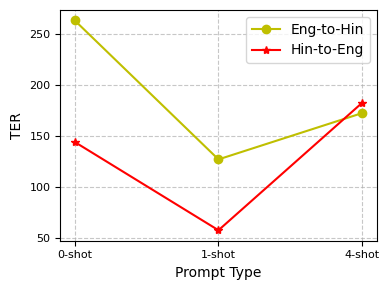


Plot for GEMMA



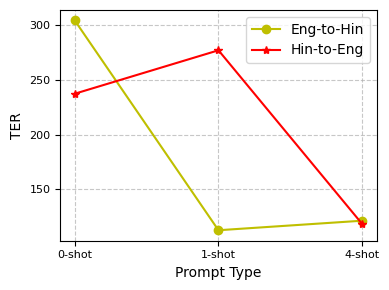

In [ ]:
import matplotlib.pyplot as plt




def displayplot (eng_hin_score,hin_eng_score):
   prompt_type= ["0-shot","1-shot", "4-shot"]

   # Plot data
   plt.figure(figsize=(4, 3))
   plt.plot(prompt_type,eng_hin_score, marker='o', color='y', label='Eng-to-Hin')
   plt.plot(prompt_type,hin_eng_score, marker='*',   color='r',label='Hin-to-Eng')

   # FOR Customizing plot

   plt.xlabel('Prompt Type',fontsize=10)

   plt.ylabel('TER',  fontsize=10)
   plt.xticks(fontsize=8)
   plt.yticks(fontsize= 8)
   plt.grid( linestyle='--',alpha=0.7 )
   plt.legend(fontsize=10)

   # Display plot
   plt.tight_layout()
   return plt


bloom_eng_hin_score = [262.92, 126.93,172.26]
bloom_hin_eng_score = [143.95, 57.58 ,182.34]
bloomshow = displayplot(bloom_eng_hin_score,bloom_hin_eng_score)
print("Plot for BLOOM\n")
bloomshow.show()

gemma_eng_hin_score = [303.82, 112.85,121.53]
gemma_hin_eng_score = [237.15, 276.68,118.58]
gemmashow = displayplot(gemma_eng_hin_score,gemma_hin_eng_score)
print("\nPlot for GEMMA\n")
gemmashow.show()


##**Loading Datsets for Sentiment analysis from Hugging Face**

In [ ]:
'''!pip install --quiet datasets'''

In [ ]:
'''from datasets import load_dataset,DatasetDict
import pandas as pd
eng="SoorajK1/sentiment_analysis_dataset-9846258f-16b8-422d-a291-965686769dca"
hin ="OdiaGenAI/sentiment_analysis_hindi"
#for english
datasetdict1 = load_dataset(eng, trust_remote_code=True)
datasetdict2 = load_dataset(eng, trust_remote_code=True)
datasetdict3 = load_dataset(eng, trust_remote_code=True)
#for hindi
datasetdict4= load_dataset(hin, trust_remote_code=True)

#loading train,validaion and test split from eng dataset
df1 = datasetdict1["train"]
df2 = datasetdict2["validation"]
df3 = datasetdict3["test"]

#convert each split to dataframe
df1 = pd.DataFrame(df1)
df2 = pd.DataFrame(df2)
df3 = pd.DataFrame(df3)


#concatenating to form 100 rows for english
df =pd.concat([df1,df2,df3],axis =0)

#dataset for hidi
df4 = datasetdict4["train"]
df4 = pd.DataFrame(df4)
df4["index"]=range(0,len(df4))

#replacing the values to positive ,negative and neutral
df4['label'] = df4['label'].replace({
    'pos': 'positive',
    'neg': 'negative',
    'neu': 'neutral'
})


df=df[['text','label_string']]

df.rename(columns={'text':'English','label_string': 'Elabel'}, inplace=True)

#merging hindi to eng dataset
df["Hindi"]=df4["text"]
df["Hlabel"]=df4["label"]

df'''

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


English    Elabel  \
0       The customer support team was very helpful  positive   
1            The price of this item is outrageous.  negative   
2               This item exceeded my expectations  negative   
3   I've had nothing but issues with this product.  positive   
4             The customer service was exceptional  positive   
..                                             ...       ...   
5       This product did not meet my expectations.  negative   
6           The customer service was very helpful.  positive   
7                     The item is of poor quality.  negative   
8                I am very happy with my purchase.  positive   
9                This item is not worth the price.  negative   

                                                Hindi    Hlabel  
0   हमें इससे बेहतर ब्राइटनेस वाले टेबलेट देखने को...  negative  
1                           बैटरी लाइफ बहुत बढिया है।  positive  
2   हकीकत ये है कि मेटल के नाम पर फोन में सिर्फ चा...   neutral  
3   स्लोफो एक मनोरंजक एप्लिकेशन है इसमें कोई दो रा...  positive  
4                              अच्छी बैटरी क्षमता है।  positive  
..                                                ...       ...  
5   बैटरी लाइफ की बात करें तो हमारे लगातार वीडियो ...  positive  
6   ये दिखने में बहुत छोटा है और इंटरनेट से कनेक्ट...   neutral  
7   इसमें ऑप्टिकल इमेज स्टेबलाइजेशन के साथ 16 एमपी...   neutral  
8   इसके अलावाइस स्मार्टफ़ोन में 1.2 GHz का क्वाड-क...   neutral  
9   हम कह सकते हैं कि ग्राफ़िक्स के मामले में डीवी6...  positive  

[100 rows x 4 columns]

##Implemenation of Generating sentiment results(BLOOM)

In [ ]:
'''import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM

# Dictionary for translation prompts
PROMPTS = {
    "input_prompts": {
        "hin_zero_shot": "Identify the sentiment in the following sentence and classify it as 'Positive' 'Negative' or 'Neutral'. Sentence:",
          "hin_one_shot": "Identify the sentiment in the Sentence and Choose 'Positive' 'Negative' or 'Neutral'.Given Example Sentences like:'कसौली हिमाचल प्रदेश का छोटा पर्वतीय स्थल है।'is classified as Neutral.Now the sentence:",
          "hin_four_shot": "Identify the sentiment in the Sentence  and Choose 'Positive' 'Negative' or 'Neutral'.Given some example Sentences like:'मनोज की भूमिका में वरुण शर्मा भी प्रभावित करते हैं।'is classified as Positive.'कसौली हिमाचल प्रदेश का छोटा पर्वतीय स्थल है।'is classified as Neutral.'देखने में बेहतर लेकिन बहुत आकर्षक नहीं।'is classified as Negative.Now the sentence:",
        "eng_zero_shot": "Identify the sentiment in the following sentence and classify it as 'Positive' 'Negative' or 'Neutral'. Sentence:",
        "eng_one_shot": "Identify the sentiment in the Sentence and Choose 'Positive' 'Negative' or 'Neutral'.Given Example Sentences like:'The food was very delicious'is classified as Positive.Now the sentence:",
        "eng_four_shot": "Identify the sentiment in the Sentence  and Choose 'Positive' 'Negative' or 'Neutral'.Given some example Sentences like:'The food was very delicious'is classified as Positive.'Lets go to the park'is classified as Neutral.'She killed her'is classified as Negative.Now the sentence:",}
}

# Translation Class
class SENTIMENT:
     def __init__(self, model_name,Tokenizer):

            self.model_name=model_name
            self.Tokenizer=Tokenizer





     def analyze_batch(self, batch, prompt):
        sentiments= []
        for sentence in batch:
            input_text = f"{prompt}{sentence} is classified as."
            inputs =self.Tokenizer(input_text, return_tensors="pt").to("cuda")
            outputs = self.model_name.generate(input_ids=inputs['input_ids'].cuda(), max_new_tokens=31, num_return_sequences=1)
            sentiment = self.Tokenizer.decode(outputs[0], skip_special_tokens=True)
            sentiment = sentiment.replace(prompt, "").strip()
            sentiments.append(sentiment)
        return sentiments

# Main Program for Translation
class Main:
    def __init__(self, dataset_sentiment, batch_size):
        self.dataset_sentiment= dataset_sentiment
        self.batch_size = batch_size
        self.num_batches = 100 // self.batch_size

    def process_inputs(self):
        # Initialize Bloom
        Tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-1b7")
        Model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-1b7", device_map="auto",load_in_4bit = True)
        bloom_analyze = SENTIMENT(Model,Tokenizer)


        results_df = pd.DataFrame(columns=[
            "Batch", "English","Hindi" ,"Elabel","Hlabel","Bloom_eng_0-shot", "Bloom_eng_1-shot", "Bloom_eng_4-shot", "Bloom_hin_0-shot", "Bloom_hin_1-shot", "Bloom_hin_4-shot"])

        for batch_num in range(self.num_batches):
            start_idx = batch_num * self.batch_size
            end_idx = start_idx + self.batch_size
            batch = self.dataset_sentiment.iloc[start_idx:end_idx]

            # Extract English and Hindi columns from the batch
            english_sentences = batch["English"].tolist()
            hindi_sentences = batch["Hindi"].tolist()

            # Bloom sentiments analyzing for Hindi and English
            bloom_english_zero_shot = bloom_analyze.analyze_batch(english_sentences, PROMPTS["input_prompts"]["eng_zero_shot"])
            bloom_english_one_shot = bloom_analyze.analyze_batch(english_sentences, PROMPTS["input_prompts"]["eng_one_shot"])
            bloom_english_four_shot = bloom_analyze.analyze_batch(english_sentences, PROMPTS["input_prompts"]["eng_four_shot"])

            bloom_hindi_zero_shot = bloom_analyze.analyze_batch(hindi_sentences, PROMPTS["input_prompts"]["hin_zero_shot"])
            bloom_hindi_one_shot = bloom_analyze.analyze_batch(hindi_sentences, PROMPTS["input_prompts"]["hin_one_shot"])
            bloom_hindi_four_shot = bloom_analyze.analyze_batch(hindi_sentences, PROMPTS["input_prompts"]["hin_four_shot"])


            # Compile batch results
            batch_data = pd.DataFrame({
                "Batch": [batch_num + 1] * len(batch),
                "English": batch["English"],
                "Hindi": batch["Hindi"],
                "Elabel": batch["Elabel"],
                "Hlabel": batch["Hlabel"],
                  "Bloom_hin_0-shot": bloom_hindi_zero_shot,
                  "Bloom_hin_1-shot": bloom_hindi_one_shot,
                "Bloom_hin_4-shot": bloom_hindi_four_shot,
                "Bloom_eng_0-shot": bloom_english_zero_shot,
                "Bloom_eng_1-shot": bloom_english_one_shot,
              "Bloom_eng_4-shot": bloom_english_four_shot,

            })
            results_df = pd.concat([results_df, batch_data], ignore_index=True)

        # Save results
        results_df.to_csv("bloomsentiments.csv", index=False)

        print("Results saved")





#batch_size =int(input("enter batch size"))
batch_size = 20
processor = Main(df, batch_size)
processor.process_inputs()'''


##Implemenation of Generating sentiment results(GEMMA)

In [ ]:
'''import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM

# Dictionary for translation prompts
PROMPTS = {
    "input_prompts": {
        "hin_zero_shot": "Identify the sentiment in the following sentence and classify it as 'Positive' 'Negative' or 'Neutral'. Sentence:",
      "hin_one_shot": "Identify the sentiment in the Sentence and Choose 'Positive' 'Negative' or 'Neutral'.Given Example Sentences like:'कसौली हिमाचल प्रदेश का छोटा पर्वतीय स्थल है।'is classified as Neutral.Now the sentence:",
      "hin_four_shot": "Identify the sentiment in the Sentence  and Choose 'Positive' 'Negative' or 'Neutral'.Given some example Sentences like:'मनोज की भूमिका में वरुण शर्मा भी प्रभावित करते हैं।'is classified as Positive.'कसौली हिमाचल प्रदेश का छोटा पर्वतीय स्थल है।'is classified as Neutral.'देखने में बेहतर लेकिन बहुत आकर्षक नहीं।'is classified as Negative.Now the sentence:",
         "eng_zero_shot": "Identify the sentiment in the following sentence and classify it as 'Positive' 'Negative' or 'Neutral'. Sentence:",
        "eng_one_shot": "Identify the sentiment in the Sentence and Choose 'Positive' 'Negative' or 'Neutral'.Given Example Sentences like:'The food was very delicious'is classified as Positive.Now the sentence:",
        "eng_four_shot": "Identify the sentiment in the Sentence  and Choose 'Positive' 'Negative' or 'Neutral'.Given some example Sentences like:'The food was very delicious'is classified as Positive.'Lets go to the park'is classified as Neutral.'She killed her'is classified as Negative.Now the sentence:"}
}

# Translation Class
class SENTIMENT:
     def __init__(self, model_name,Tokenizer):

            self.model_name=model_name
            self.Tokenizer=Tokenizer





     def analyze_batch(self, batch, prompt):
        sentiments = []
        for sentence in batch:
            input_text = f"{prompt}{sentence} is classified as."
            inputs =self.Tokenizer(input_text, return_tensors="pt").to("cuda")

            outputs = self.model_name.generate(input_ids=inputs['input_ids'].cuda(), max_new_tokens=31, num_return_sequences=1)
            sentiment = self.Tokenizer.decode(outputs[0], skip_special_tokens=True)


            sentiment = sentiment.replace(prompt, "").strip()
            sentiments.append(sentiment)
        return sentiments

# Main Program for Translation
class Main:
    def __init__(self, dataset_sentiment, batch_size):
        self.dataset_sentiment= dataset_sentiment
        self.batch_size = batch_size
        self.num_batches = 100 // self.batch_size

    def process_inputs(self):
        # Initialize gemma
        Tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
        Model = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b", device_map="auto",load_in_8bit = True)
        gemma_analyze = SENTIMENT(Model,Tokenizer)


        results_df = pd.DataFrame(columns=[
            "Batch", "English","Hindi","Elabel","Hlabel", "GEMMA_eng_0-shot", "GEMMA_eng_1-shot", "GEMMA_eng_4-shot", "GEMMA_hin_0-shot", "GEMMA_hin_1-shot", "GEMMA_hin_4-shot"
        ])

        for batch_num in range(self.num_batches):
            start_idx = batch_num * self.batch_size
            end_idx = start_idx + self.batch_size
            batch = self.dataset_sentiment.iloc[start_idx:end_idx]

            # Extract English and X-Language columns from the batch
            english_sentences = batch["English"].tolist()
            hindi_sentences = batch["Hindi"].tolist()

            # Bloom translations (X->English and English->X)
            gemma_english_zero_shot = gemma_analyze.analyze_batch(english_sentences, PROMPTS["input_prompts"]["eng_zero_shot"])
            gemma_english_one_shot = gemma_analyze.analyze_batch(english_sentences, PROMPTS["input_prompts"]["eng_one_shot"])
            gemma_english_four_shot = gemma_analyze.analyze_batch(english_sentences, PROMPTS["input_prompts"]["eng_four_shot"])

              gemma_hindi_zero_shot = bloom_analyze.analyze_batch(hindi_sentences, PROMPTS["input_prompts"]["hin_zero_shot"])
            gemma_hindi_one_shot = bloom_analyze.analyze_batch(hindi_sentences, PROMPTS["input_prompts"]["hin_one_shot"])
            gemma_hindi_four_shot = bloom_analyze.analyze_batch(hindi_sentences, PROMPTS["input_prompts"]["hin_four_shot"])


            # Compile batch results
            batch_data = pd.DataFrame({
                "Batch": [batch_num + 1] * len(batch),
                "English": batch["English"],

              "Hindi": batch["Hindi"],
                "Elabel": batch["Elabel"],
                "Hlabel": batch["Hlabel"],

                "GEMMA_eng_0-shot": gemma_english_zero_shot,
                 "GEMMA_eng_1-shot": gemma_english_one_shot,
                "GEMMA_eng_4-shot": gemma_english_four_shot,
                "GEMMA_hin_0-shot": gemma_english_zero_shot,
                 "GEMMA_hin_1-shot": gemma_english_one_shot,
                "GEMMA_hin_4-shot": gemma_english_four_shot})
            results_df = pd.concat([results_df, batch_data], ignore_index=True)

        # Save results
        results_df.to_csv("gemmasentiment_results.csv", index=False)

        print("Results saved")





#batch_size =int(input("enter batch size"))
batch_size = 20
processor = Main(df, batch_size)
processor.process_inputs()
'''

Implemenation for Evaluation of generated Sentimens

In [ ]:
#could not be done due to high ambiguity in outputs generated

#**Loading large models on small GPU's**

In [ ]:
#installing prerequisites
#bitsandbytes for applying QUaatization
!pip install --quiet  -U bitsandbytes
!pip install --quiet --upgrade transformers
!pip install --quiet  accelerate

##Prompting BLOOM and GEMMA models for Translation and Cross lingual summarizatiion

In [ ]:
from transformers import AutoTokenizer,AutoModelForCausalLM
from transformers import  pipeline


In [ ]:
#for granted access to  gemma model use your hf token
from huggingface_hub import login,logout
login()


In [ ]:
#Used Bloom 7B  and Gemma
#name= "bigscience/bloom-7b"
name ="google/gemma-2-2b"
pipe =pipeline(model=name, model_kwargs={"device_map": "auto","load_in_8bit":"True"})


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


In [ ]:
#Run these exaples to check outputs for Translation
pipe("Translate the Sentence from English to Hindi.Example sentence:'But make sure you watch the part of the parade'translates to Hindi as'लेकिन प्रतियोगि+ता के कारण परेड का जो भाग मैं म'.Now translate the sentence:Do not bother about the prizes.")
#pipe("Translate the sentence from English to Hindi.Given some example sentences like:'But make sure you watch the part of the parade'translates to Hindi as'लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'.'I will hear about it at bedtime'translates to Hindi as'रात को सोने से पहले उसके बारे में सुनूंगी।'.'Hello, is this Samadhan helpline?'translates to Hindi as'हेलो, क्या यह समाधान हेल्पलाइन है?'.'Yes, how can I help you?'translates to Hindi as'हाँ, मैं आपकी कैसे सहायता कर सकता हूँ?'.Now translate the sentence:Do not bother about the prizes.")
#pipe("Translate the sentence from Hindi to English.Example sentence:लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'translates to English as'But make sure you watch the part of the parade'.Now translate the sentence:मैं पढ़ाई नहीं करना चाहता.")
#pipe("Translate the sentence from Hindi to English.Given some example sentences like:'लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'translates to English as'But make sure you watch the part of the parade'.'रात को सोने से पहले उसके बारे में सुनूंगी।'translates to English as'I will hear about it at bedtime'.'हेलो, क्या यह समाधान हेल्पलाइन है?'translates to English as'Hello, is this Samadhan helpline?'.'हाँ, मैं आपकी कैसे सहायता कर सकता हूँ?'translates to English as'Yes, how can I help you?'.Now translate the sentence:मुझे कल स्कूल नहीं जाना है।.")

In [ ]:
#Run these examples to check outputs for coross lingual summarization
#Input_text="A computer is a machine that can be programmed to automatically carry out sequences of arithmetic or logical operations. Modern digital electronic computers can perform generic sets of operations known as programs. These programs enable computers to perform a wide range of tasks. The term computer system may refer to a nominally complete computer that includes the hardware, operating system, software, and peripheral equipment needed and used for full operation; or to a group of computers that are linked and function together, such as a computer network or computer cluster."
Input_text ="India is home to one of the world’s oldest civilizations, and has a history of great empires like the Maurya and Mughal empires.India is the largest democracy in the world, where people elect their leaders."
pipe(f"Please first translate the following text to Hindi and then summarize the translated text in Hindi: {Input_text}")
#pipe(f"Please first summarize the following text and then translate the summary to Chinese:{Input_text}")
#pipe(f"Summarize the following text in Chinese: {Input_text}")

[{'generated_text': 'Please first translate the following text to Hindi and then summarize the translated text in Hindi: India is home to one of the world’s oldest civilizations, and has a history of great empires like the Maurya and Mughal empires.India is the largest democracy in the world, where people elect their leaders. India is a country of diverse cultures, religions, and languages. India is a country of diverse cultures'}]

##Analyzing the generation speed of BLOOM and Gemma for Translation in both 8-bit and 4-bit Quantization along with varying batch sizes**

In [ ]:
import pandas as pd
import time
from transformers import AutoTokenizer, AutoModelForCausalLM

def process_batches(dataframe,batch_size, model,tokenizer,prompt):


    sentences = dataframe['sentence_eng_Latn'].tolist()

    total_batches =[sentences[i: i+batch_size] for i in range(0, len(sentences), batch_size)]
    translations =[]
    batch_times =[]

    # Start processing batches
    print("Processing batch...")
    for batch_num, batch in enumerate(total_batches, start=1):

        print(f"{batch_num}/{len(total_batches)}",end = " ")
        batch_start_time = time.time()

        # Process each batch
        batch_translations =[]
        for sentence in batch:
            input_text =f"{prompt}{sentence}."

            inputs =tokenizer(input_text, return_tensors="pt").to("cuda")
            outputs =model.generate(
                input_ids =inputs['input_ids'].cuda(),
                max_new_tokens =31,
                num_return_sequences =1
            ).to("cuda")
            translation =tokenizer.decode(outputs[0], skip_special_tokens=True)
            translation =translation.replace(prompt, "").strip()
            batch_translations.append(translation)

        # Record time taken for this batch
        batch_end_time =time.time()
        batch_time = batch_end_time - batch_start_time
        batch_times.append(batch_time)


        # Append translations
        translations.extend(batch_translations)

    # Calculate total time for all batches
    total_time =  sum(batch_times)
    print(f"\nTotal time to process all batches: {total_time:.2f} seconds")

    return  total_time




    # specify model and tokenizer accordinlgy(not included in timing)
tokenizer =  AutoTokenizer.from_pretrained("google/gemma-2-2b")
model =AutoModelForCausalLM.from_pretrained("google/gemma-2-2b",device_map ="auto")
batch_size =int(input("enter batch size 2,10,20 or 50"))

prompt = "Translate the sentence from English to Hindi.Given some example sentences like:'But make sure you watch the part of the parade'translates to Hindi as'लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'.'I will hear about it at bedtime'translates to Hindi as'रात को सोने से पहले उसके बारे में सुनूंगी।'.'Hello, is this Samadhan helpline?'translates to Hindi as'हेलो, क्या यह समाधान हेल्पलाइन है?'.'Yes, how can I help you?'translates to Hindi as'हाँ, मैं आपकी कैसे सहायता कर सकता हूँ?'.Now translate the sentence:"

#   Process batches and   get translations and timing
#also load dta from hf first from cell no 6

total_time =process_batches(translationdata, batch_size, model, tokenizer, prompt)

print("Total Processing Time:", total_time)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Processing batch...
1/5 2/5 3/5 4/5 5/5 
Total time to process all batches: 857.33 seconds
Total Processing Time: 857.3349697589874



##Trying Largest models: BlOOM (7.07B) and GEMMA (9.24B,7B,2.61B)**

###**Loading BlOOM (7.07B) using 8-bit and 4-bit quantization**

In [ ]:
from transformers import pipeline
name = "bigscience/bloom-7b1"
#replace "load_in_8bit": True to "load_in_4-bit":True for 4-bit quantization in the pipelines argument
pipe =pipeline(model=name, model_kwargs= {"device_map": "auto", "load_in_4bit": True})


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


###**Loading GEMMA(9.24B,7B,2.61B) using 8-bit and 4-bit quantization**

In [ ]:
#for granted access to  gemma model use your hf token
from huggingface_hub import login,logout
login()


In [ ]:
from transformers import pipeline
name ="google/gemma-2-9b"#specify the model accordingly


#replace "load_in_8bit": True to "load_in_4-bit":True for 4-bit quantization in the pipelines argument
pipe =pipeline(model=name, model_kwargs= {"device_map": "auto", "load_in_4bit": True})


config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/4.84G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/2.38G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Device set to use cuda:0


#**Testing Different Prompts**

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM
name = "bigscience/bloom-1b7"
max_new_tokens = 31
#name="google/gemma-2-2b"
pipe = pipeline(model=name, model_kwargs= {"device_map": "auto", "load_in_8bit": True},max_new_tokens=max_new_tokens)

##Prompts for BLOOM and GEMMA

### Translation

####english -hindi

In [ ]:
pipe("Translate the Sentence to Hindi language: Dont bother about the prizes.")

[{'generated_text': 'Translate the Sentence to Hindi language: Dont bother about the prizes. The best part is that you can use the same sentence in Hindi and English. The best part is that you can use the same sentence in Hindi and English'}]

In [ ]:
pipe("Translate the Sentence from English to Hindi.Example sentence:'But make sure you watch the part of the parade'translates to Hindi as'लेकिन प्रतियोगि+ता के कारण परेड का जो भाग मैं म'.Now translate the sentence:Do not bother about the prizes.")

[{'generated_text': "Translate the Sentence from English to Hindi.Example sentence:'But make sure you watch the part of the parade'translates to Hindi as'लेकिन प्रतियोगि+ता के कारण परेड का जो भाग मैं म'.Now translate the sentence:Do not bother about the prizes.Example sentence:'आप चिंता मत करो, आप सभी को पुरस्कृत करेंगे'translates to Hindi as'आप चिंता मत करो, आप सभी को पुरस्कृत करेंगे"}]

In [ ]:
pipe("Translate the sentence from English to Hindi.Given some example sentences like:'But make sure you watch the part of the parade'translates to Hindi as'लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'.'I will hear about it at bedtime'translates to Hindi as'रात को सोने से पहले उसके बारे में सुनूंगी।'.'Hello, is this Samadhan helpline?'translates to Hindi as'हेलो, क्या यह समाधान हेल्पलाइन है?'.'Yes, how can I help you?'translates to Hindi as'हाँ, मैं आपकी कैसे सहायता कर सकता हूँ?'.Now translate the sentence:Do not bother about the prizes.")

[{'generated_text': "Translate the sentence from English to Hindi.Given some example sentences like:'But make sure you watch the part of the parade'translates to Hindi as'लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'.'I will hear about it at bedtime'translates to Hindi as'रात को सोने से पहले उसके बारे में सुनूंगी।'.'Hello, is this Samadhan helpline?'translates to Hindi as'हेलो, क्या यह समाधान हेल्पलाइन है?'.'Yes, how can I help you?'translates to Hindi as'हाँ, मैं आपकी कैसे सहायता कर सकता हूँ?'.Now translate the sentence:Do not bother about the prizes.'translates to Hindi as'आप चिंता मत करो, पुरस्कारों के बारे में मत सोचो।'.'Hello, is this Samadhan"}]

In [ ]:
pipe("Translate the sentence from English to Hindi.Given some example sentences like:'But make sure you watch the part of the parade'translates to Hindi as'लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'.'I will hear about it at bedtime'translates to Hindi as'रात को सोने से पहले उसके बारे में सुनूंगी।'.'Hello, is this Samadhan helpline?'translates to Hindi as'हेलो, क्या यह समाधान हेल्पलाइन है?'.'Yes, how can I help you?'translates to Hindi as'हाँ, मैं आपकी कैसे सहायता कर सकता हूँ?'.Now translate the sentence:I don't have to go to school to Hindi.")

[{'generated_text': "Translate the sentence from English to Hindi.Given some example sentences like:'But make sure you watch the part of the parade'translates to Hindi as'लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'.'I will hear about it at bedtime'translates to Hindi as'रात को सोने से पहले उसके बारे में सुनूंगी।'.'Hello, is this Samadhan helpline?'translates to Hindi as'हेलो, क्या यह समाधान हेल्पलाइन है?'.'Yes, how can I help you?'translates to Hindi as'हाँ, मैं आपकी कैसे सहायता कर सकता हूँ?'.Now translate the sentence:I don't have to go to school to Hindi.Given some example sentences like:'I don't have to go to school to learn'translates to Hindi as'मैं पढ़ाई नहीं करना चाहता'.'I"}]

####hindi-english

In [ ]:
pipe("Translate the given sentence to English language:मुझे कल स्कूल नहीं जाना है।.")

[{'generated_text': 'Translate the given sentence to English language:मुझे कल स्कूल नहीं जाना है।.'}]

In [ ]:
 pipe("Translate the sentence from Hindi to English.Example sentence:लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'translates to English as'But make sure you watch the part of the parade'.Now translate the sentence:मैं पढ़ाई नहीं करना चाहता.")

[{'generated_text': "Translate the sentence from Hindi to English.Given some example sentences like:लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'translates to English as'But make sure you watch the part of the parade'.'रात को सोने से पहले उसके बारे में सुनूंगी।'translates to English as'I will hear about it at bedtime'. 'हेलो, क्या यह समाधान हेल्पलाइन है?'translates to English as'Hello, is this Samadhan helpline?'.'हाँ, मैं आपकी कैसे सहायता कर सकता हूँ?'translates to English as'Yes, how can I help you?'.Now translate the sentence:मैं पढ़ाई नहीं करना चाहता.'translates to English as'I don't want to study.'.'मैं पढ़ाई नहीं करना चाहता.'translates to English as'"}]

In [ ]:
pipe("Translate the sentence from Hindi to English.Given some example sentences like:'लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'translates to English as'But make sure you watch the part of the parade'.'रात को सोने से पहले उसके बारे में सुनूंगी।'translates to English as'I will hear about it at bedtime'.'हेलो, क्या यह समाधान हेल्पलाइन है?'translates to English as'Hello, is this Samadhan helpline?'.'हाँ, मैं आपकी कैसे सहायता कर सकता हूँ?'translates to English as'Yes, how can I help you?'.Now translate the sentence:मुझे कल स्कूल नहीं जाना है।.")

[{'generated_text': "Translate the sentence from Hindi to English.Given some example sentences like:'लेकिन प्रतियोगिता के कारण परेड का जो भाग मैं म'translates to English as'But make sure you watch the part of the parade'.'रात को सोने से पहले उसके बारे में सुनूंगी।'translates to English as'I will hear about it at bedtime'.'हेलो, क्या यह समाधान हेल्पलाइन है?'translates to English as'Hello, is this Samadhan helpline?'.'हाँ, मैं आपकी कैसे सहायता कर सकता हूँ?'translates to English as'Yes, how can I help you?'.Now translate the sentence:मुझे कल स्कूल नहीं जाना है।.'translates to English as'I am not going to school today.'.'आप मुझे कल स्कूल नहीं जाना है।'translates"}]

###Senetiment analysis

####english

In [ ]:
pipe("Identify the sentiment in the following sentence as 'Positive' 'Negative' or 'Neutral'. Sentence:'The item is of poor quality'. ")

[{'generated_text': "Identify the sentiment in the following sentence as 'Positive' 'Negative' or 'Neutral'. Sentence:'The food there was delicious'. "}]

In [ ]:
pipe("Identify the sentiment in the Sentence and Choose 'Positive' 'Negative' or 'Neutral'.Given Example Sentencelike:'The food was very delicious'is classified as Positive.Now the sentence:She was washing her clother is classified as.")

In [ ]:
pipe("Identify the sentiment in the Sentence  and Choose 'Positive' 'Negative' or 'Neutral'.Given Example Sentence like:'The food was very delicious'is classified as Positive.'Lets go to the park'is classified as Neutral.'She killed her'is classified as Negative.'The dog ate the biscuit'is classified as Neutral.Now the sentence:The soldier ran to save people is classified as.")

[{'generated_text': "Identify the sentiment in the Sentence  and Choose 'Positive' 'Negative' or 'Neutral'.Given Example Sentence like:'The food was very delicious'is classified as Positive.'Lets go to the park'is classified as Neutral.'She killed her'is classified as Negative.'The dog ate the biscuit'is classified as Neutral.'Now the sentence:She gave her a necklace as a gift on her birthday is classified as.Positive.'She gave her a necklace as a gift on her birthday is classified as.Positive.'She gave her a necklace as a gift"}]

####hindi

In [ ]:
pipe("Identify the sentiment in the following sentence and classify it as 'Positive' 'Negative' or 'Neutral'.Sentence:यह चटख रंगों और शार्प डीटेल वाले शानदार फोटो लेता है। is classified as. ")


In [ ]:
pipe("Identify the sentiment in the Sentence and Choose 'Positive' 'Negative' or 'Neutral'.Given Example Sentences like:'कसौली हिमाचल प्रदेश का छोटा पर्वतीय स्थल है।'is classified as Neutral.Now the sentence:यह चटख रंगों और शार्प डीटेल वाले शानदार फोटो लेता है। is classified as.")


In [ ]:
pipe("Identify the sentiment in the Sentence  and Choose 'Positive' 'Negative' or 'Neutral'.Given some example Sentences like:'मनोज की भूमिका में वरुण शर्मा भी प्रभावित करते हैं।'is classified as Positive.'कसौली हिमाचल प्रदेश का छोटा पर्वतीय स्थल है।'is classified as Neutral.'देखने में बेहतर लेकिन बहुत आकर्षक नहीं।'is classified as Negative.Now the sentence:यह चटख रंगों और शार्प डीटेल वाले शानदार फोटो लेता है। is classified as.")
